In [1]:
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import linregress
import numpy as np
import psycopg2
import matplotlib.pyplot as plt

Extract CSV files into DataFrames

In [2]:
netflix_file = "Resources/netflix_data_clean.csv"
netflix_df = pd.read_csv(netflix_file)
netflix_df.head(2)

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
1,20,80060297,Movie,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",United States,"September 8, 2017",2014,TV-14,98 min,"Comedies, Independent Movies, Romantic Movies",A filmmaker working on a documentary about lov...


In [3]:
omdb_file = "Resources/omdb_data_clean.csv"
omdb_df = pd.read_csv(omdb_file)
omdb_df.head(2)

,Unnamed: 0,title,genre,language,awards,metascore,boxoffice,production,imdbrating,imdbvotes,imdbid
0,1,Manhattan Romance,"Comedy, Drama, Romance",English,3 wins.,NaN,NaN,Beacon Films Inc.,5.5,"1,122",tt2608324
1,2,Stonehearst Asylum,"Drama, Horror, Thriller",English,1 win & 1 nomination.,52.0,NaN,Millenium Entertainment,6.8,"48,493",tt1772264


In [4]:
tmdb_file = "Resources/tmdb_data_clean.csv"
tmdb_df = pd.read_csv(tmdb_file)
tmdb_df.head(2)

,Unnamed: 0,title,original_title,popularity,vote_count,vote_average,poster_path
0,1,Manhattan Romance,Manhattan Romance,3.765,24,4.8,na
1,2,Stonehearst Asylum,Stonehearst Asylum,17.405,817,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...


Transform Netflix and the Open Movie DB DataFrames

In [5]:
# Create a filtered on the Netflix dataframe from specific columns
netflix_columns = ["show_id", "title", "director", "cast", "release_year", "listed_in", "rating", "duration", "description"]
netflix_transformed= netflix_df[netflix_columns].copy()

# Rename the column headers
netflix_transformed = netflix_transformed.rename(columns={"show_id": "id",
                                                          "listed_in": "netflix_genre", 
                                                          "release_year": "year_released", 
                                                          "cast":"cast_members"})

# Clean the data by dropping duplicates and setting the index
netflix_transformed.drop_duplicates("id", inplace=True)
netflix_transformed.set_index("id", inplace=True)

netflix_transformed.head(2)

,title,director,cast_members,year_released,netflix_genre,rating,duration,description
id,,,,,,,,
80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",2017,Comedies,TV-14,99 min,When nerdy high schooler Dani finally attracts...
80060297,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",2014,"Comedies, Independent Movies, Romantic Movies",TV-14,98 min,A filmmaker working on a documentary about lov...


In [6]:
 # Create a filtered on the Open Move DB dataframe from specific columns
omdb_columns = ["title", "genre", "language", "awards", "production", "imdbid", "imdbrating", "metascore", "boxoffice"]
omdb_transformed= omdb_df[omdb_columns].copy()

omdb_transformed = omdb_transformed.rename(columns={"genre": "omdb_genre"})

omdb_transformed["boxoffice"]=omdb_transformed["boxoffice"].str.replace('$', '')
omdb_transformed["boxoffice"]=omdb_transformed["boxoffice"].str.replace(',', '')
#omdb_transformed["boxoffice"]=omdb_transformed["boxoffice"].astype(float)

# Clean the data by dropping duplicates and setting the index
omdb_transformed.drop_duplicates("imdbid", inplace=True)
omdb_transformed.set_index("imdbid", inplace=True)

omdb_transformed.head(2)

,title,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice
imdbid,,,,,,,,
tt2608324,Manhattan Romance,"Comedy, Drama, Romance",English,3 wins.,Beacon Films Inc.,5.5,NaN,NaN
tt1772264,Stonehearst Asylum,"Drama, Horror, Thriller",English,1 win & 1 nomination.,Millenium Entertainment,6.8,52.0,NaN


In [7]:
 # Create a filtered on the Open Move DB dataframe from specific columns
tmdb_columns = ["title", "original_title", "popularity", "vote_count", "vote_average", "poster_path"]
tmdb_transformed= tmdb_df[tmdb_columns].copy()

tmdb_transformed.head(2)

,title,original_title,popularity,vote_count,vote_average,poster_path
0,Manhattan Romance,Manhattan Romance,3.765,24,4.8,na
1,Stonehearst Asylum,Stonehearst Asylum,17.405,817,6.7,https://image.tmdb.org/t/p/w500/fZxGCCQ0NAtrae...


### Create a database connection ###

In [8]:
connection_string = "postgres:postgres@localhost:5432/movies_db"
engine = create_engine(f'postgresql://{connection_string}')

In [9]:
# Confirm tables were created
engine.table_names()

['omdb', 'netflix', 'tmdb']

### Load Transformed DF data into the DB ###

In [10]:
netflix_transformed.to_sql(name='netflix', con=engine, if_exists='append', index=True)

In [11]:
omdb_transformed.to_sql(name='omdb', con=engine, if_exists='append', index=True)

In [12]:
tmdb_transformed.to_sql(name='tmdb', con=engine, if_exists='append', index=False)

### Merge Data into a single functional table ###

In [13]:
merge_table1 = pd.merge(netflix_transformed, omdb_transformed, on="title", how="outer")
merge_table1.head(2)

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice
0,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",2017.0,Comedies,TV-14,99 min,When nerdy high schooler Dani finally attracts...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",2014.0,"Comedies, Independent Movies, Romantic Movies",TV-14,98 min,A filmmaker working on a documentary about lov...,"Comedy, Drama, Romance",English,3 wins.,Beacon Films Inc.,5.5,NaN,NaN


In [14]:
final_table = pd.merge(merge_table1, tmdb_transformed, on="title", how="outer")
final_table_clean = final_table.drop_duplicates("title")
final_table_clean.head(2)

,title,director,cast_members,year_released,netflix_genre,rating,duration,description,omdb_genre,language,awards,production,imdbrating,metascore,boxoffice,original_title,popularity,vote_count,vote_average,poster_path
0,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",2017.0,Comedies,TV-14,99 min,When nerdy high schooler Dani finally attracts...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",2014.0,"Comedies, Independent Movies, Romantic Movies",TV-14,98 min,A filmmaker working on a documentary about lov...,"Comedy, Drama, Romance",English,3 wins.,Beacon Films Inc.,5.5,NaN,NaN,Manhattan Romance,3.765,24.0,4.8,na


In [15]:
box_office_movies = final_table_clean.dropna(subset=["boxoffice"])
box_office_movies = box_office_movies.loc[box_office_movies["boxoffice"]!='na']
box_office_movies["boxoffice"] = box_office_movies["boxoffice"].astype(float)

### Begin Graphing ###

The r-squared is: 0.02749812468449879


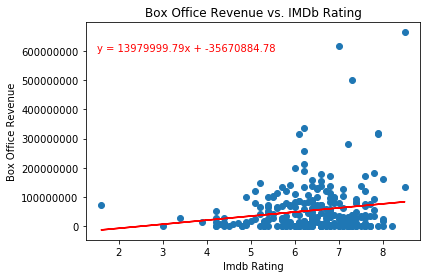

In [16]:
# Scatter plot Box Office Revenue vs IMDB Rating
x_values = box_office_movies['imdbrating']
y_values = box_office_movies['boxoffice']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1.5,600000000),fontsize=10,color="red")
plt.title('Box Office Revenue vs. IMDb Rating')
plt.xlabel('Imdb Rating')
plt.ylabel('Box Office Revenue')
#Turn off the scientific notation (ie8)
plt.ticklabel_format(style="Plain")
print(f"The r-squared is: {rvalue**2}")
plt.savefig('Resources/Chart - Box Office vs IMDB Rating.png')
plt.show()

In [17]:
# Drop NA from Popularity
box_office_popularity = box_office_movies.dropna(subset=["popularity"])

# Drop NA from Vote Count
box_office_vote_count = box_office_movies.dropna(subset=["vote_count"])

The r-squared is: 0.6189010072905601


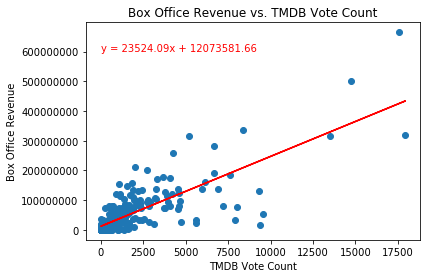

In [18]:
# Scatter Plot Vote Count vs. Box Office
x_values = box_office_vote_count['vote_count']
y_values = box_office_vote_count['boxoffice']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,600000000),fontsize=10,color="red")
plt.title('Box Office Revenue vs. TMDB Vote Count')
plt.xlabel('TMDB Vote Count')
plt.ylabel('Box Office Revenue')
#Turn off the scientific notation (ie8)
plt.ticklabel_format(style="Plain")
print(f"The r-squared is: {rvalue**2}")
plt.savefig('Resources/Chart - Box Office vs TMDB Vote Count.png')
plt.show()

In [19]:
#drop na from popularity and imdb rating columns:
popularity_clean = final_table_clean.dropna(subset=["popularity"])
popularity_imdb_rating_clean = popularity_clean.dropna(subset=["imdbrating"])

The r-squared is: 0.03227586060151234


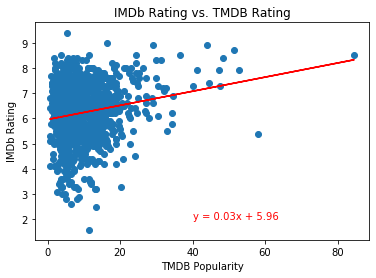

In [20]:
# Scatter Plot IMDB Ratings vs. Popularity
x_values = popularity_imdb_rating_clean['popularity']
y_values = popularity_imdb_rating_clean['imdbrating']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,2),fontsize=10,color="red")
plt.title('IMDb Rating vs. TMDB Rating')
plt.xlabel('TMDB Popularity')
plt.ylabel('IMDb Rating')
print(f"The r-squared is: {rvalue**2}")
plt.savefig('Resources/Chart - IMDB Rating vs TMDB Rating.png')
plt.show()

In [21]:
#drop na from metascore and imdb rating columns:
metascore_clean = final_table_clean.dropna(subset=["metascore"])
metascore_imdb_rating_clean = metascore_clean.dropna(subset=["imdbrating"])

The r-squared is: 0.4117996177648918


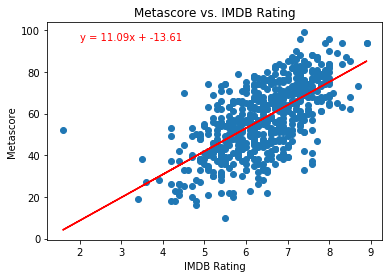

In [22]:
# Scatter Plot IMDB Rating and metascore 
x_values = metascore_imdb_rating_clean['imdbrating']
y_values = metascore_imdb_rating_clean['metascore']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2,95),fontsize=10,color="red")
plt.title('Metascore vs. IMDB Rating')
plt.xlabel('IMDB Rating')
plt.ylabel('Metascore')
print(f"The r-squared is: {rvalue**2}")
plt.savefig('Resources/Chart - Metascore vs IMDB Rating.png')
plt.show()

In [23]:
#drop na from metascore and tmdb rating columns:
metascore_tmdb_rating_clean = metascore_clean.dropna(subset=["vote_average"])

The r-squared is: 0.33088010463108447


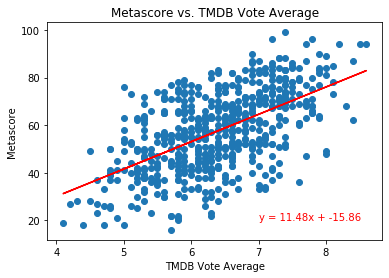

In [24]:
# Scatter plot vote average vs. Metascore
x_values = metascore_tmdb_rating_clean['vote_average']
y_values = metascore_tmdb_rating_clean['metascore']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(7,20),fontsize=10,color="red")
plt.title('Metascore vs. TMDB Vote Average')
plt.xlabel('TMDB Vote Average')
plt.ylabel('Metascore')
print(f"The r-squared is: {rvalue**2}")
plt.savefig('Resources/Chart - Metascore vs TMDB Rating.png')
plt.show()